<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Hemmat/Hemmat_L-6-6_H-128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [49]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [50]:
!nvidia-smi

Fri Jul 17 18:54:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   9785MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
!git clone https://github.com/mmsamiei/transformers-zirab
%cd transformers-zirab/
%pip install .

Cloning into 'transformers-zirab'...
remote: Enumerating objects: 34926, done.
remote: Total 34926 (delta 0), reused 0 (delta 0), pack-reused 34926
Receiving objects: 100% (34926/34926), 25.43 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (24158/24158), done.
/content/transformers-zirab/transformers-zirab
Processing /content/transformers-zirab/transformers-zirab
  Created wheel for transformers: filename=transformers-3.0.2-cp36-none-any.whl size=789366 sha256=45d71b96870ca4d1d91d89ee86ad2561e85a46914e74a95b1522a2e7461f4733
  Stored in directory: /root/.cache/pip/wheels/64/19/4d/b8a1339bb892f654ab731fafe8cae9a7f652c7ff20ff08b7cb
Successfully built transformers
  Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2


In [53]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [54]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'
opensubtitle_file = '/content/drive/My Drive/Thesis/phase-3/opensubtitle.csv'

In [55]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-6_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-6_H-128_A-2')

In [56]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        # self.dialogues = self.dialogues.sample(frac=frac)
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [57]:
train_dataset = MyDataset(train_file, max_len=128, split_rate=1, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_seen_dataset))
print(len(test_unseen_dataset))

41489
4458
2224
2075


In [58]:
print(enc_tokenizer.decode(train_dataset[1000]['input_pair']))
print(dec_tokenizer.decode(train_dataset[1000]['response']))

[CLS] is your favorite beatles song? [SEP] " love me do " that came out in 1962 - it's a great tune! [SEP] i have never heard that one. the beatles were before my time. [SEP] you really missed out! their first performance in the u. s. on the ed sullivan show was epic! " beatlemania " had begun! [SEP] oh wow, maybe i will have to go and listen to some of their music. do you have an album that you recommend? [SEP] with members john lennon, paul mccartney, george harrison and ringo starr, they became widely regarded as the foremost and most influential music band. [SEP]
[CLS] abbey road, without a doubt! many people considered the beatles as the most influential music band! [SEP]


In [59]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 82])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 45])
****
649
70


# Model

In [60]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-6_H-128_A-2', 'google/bert_uncased_L-6_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    kwargs ['token_type_ids'] = segments_tensors
    generated = model.seq2seq.generate(input_ids=encoder_input,
        decoder_start_token_id=101,bos_token_id=101,
        eos_token_id=102, **kwargs)

    #### generated = [1, len]
    return generated

  def zirab_generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0).to(dev)
    segments_tensors = segments_tensors.unsqueeze(0).to(dev)
    decoder_input = torch.LongTensor([[101]]).to(dev)
    model_forward_kwargs = {}
    model_forward_kwargs['token_type_ids'] = segments_tensors
    for i in range(30):
      outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **model_forward_kwargs )[0] # (1,len,30522)
      vocab_scores = outputs[0,-1,:]
      selected_vocab = torch.argmax(vocab_scores)
      decoder_input = torch.cat((decoder_input, selected_vocab.unsqueeze(0).unsqueeze(0)), 1)
      if selected_vocab.item() == 102:
        break
    return decoder_input
    ### decoder_input = [1, len]
    

In [61]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

Some weights of the model checkpoint at google/bert_uncased_L-6_H-128_A-2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google/bert_uncased_L-6_H-128_A-2 and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.sel

10803130


#Optimizer



In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [63]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)

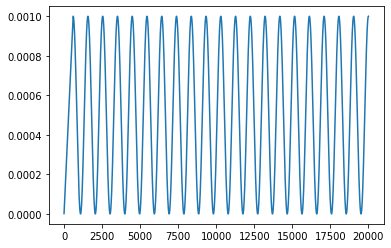

In [ ]:
lrs = []
for i in tqdm(range(20000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [64]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

In [65]:
def get_weights(_lambda = 0.4):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [66]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    print("Easy training")
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [67]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':16,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  #kwargs = {}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          'top-k':1
          }
  #kwargs = {}
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=100, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [ ]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Hemmat/L-2-2_H-128/"
  step = 0
  log_list = []

In [68]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Hemmat/L-6-6_H-128/"
checkpoint = torch.load(model_dir+'/hemmat_60000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

60000


In [48]:
from tqdm.auto import tqdm

MAX_STEP = 60000
STEP_SAVE = 1000
STEP_CHECK = 1000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict()
            }, model_dir+'hemmat_{}steps.model'.format(step_num))
    step_num += 1

40001


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] i'm not sure, but it's a long way to go to the beach.
model says:  [CLS] i'm not sure, but it's a long way to go to the state of
model says:  [CLS] i'm not sure, but it's a long way to go to the beach,
model says:  [CLS] i'm not sure. it's a long way to visit hiking. it is a
model says:  [CLS] i'm not sure, but it's a long way to go hiking. it '
model says:  [CLS] i'm not sure, but it's a lot of people in the countryside. [SEP]
model says:  [CLS] i'm not sure. it's a long way to go to the state of the
model says:  [CLS] i'm not sure, but it's a long way to go to the countryside.
most greedy sentence:
pair is:  [CLS] hi

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is used to refer to the countryside. it's a long walk in the countryside,
model says:  [CLS] hiking is used to refer to the countryside. it's a long walk on the countryside,
model says:  [CLS] hiking is a long walk in the countryside. it's called " hikes ", "
model says:  [CLS] hiking is used to refer to the countryside. it's a long walk in the countryside and
model says:  [CLS] hiking is used to refer to the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is used to refer to the countryside. it's called " hikes ", "
model says:  [CLS] hiking is used to refer to

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is used to be used in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is used in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is usually used in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is usually used in the countryside. it's used to be used as a vigorous walk
model says:  [CLS] hiking is usually used in the countryside. it's used to be used in a countryside.
model says:  [CLS] hiking is usually used in the countryside. it's us

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is used to be used for long walks. it's used for a long walk.
model says:  [CLS] hiking is used for long walks. it's used to be used for a long walk.
model says:  [CLS] hiking is used to be used for long walks. it's a long walk on trails,
model says:  [CLS] hiking is used to be used for long walks. it's used for a long walk,
model says:  [CLS] hiking is used for long walks. it's used to be used for a long walk,
model says:  [CLS] hiking is used to be used for long walks. it's a long walk on trails.
model says:  [CLS] hiking can be used for long walks. hiking is used for walking, hiking, and hiking.
model says:  

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for long walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for long walks. it's a long vigorous walk on trails,
model says:  [CLS] hiking is the preferred term for long walks. it's a long walk on trails. [SEP]
model says:  [CLS] hiking is the preferred term for long walks. it's a long vigorous walk. [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for long walks. it's a long vigorous walk on trails.
model says:  [CLS] hiking is used for a long vigorous walk. it's a long walk on trails. [SEP]
model says:  [CLS] hikin

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks, in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. it's used for shorter, vigorous walks,
model says:  [CLS] hiking is the preferred term for shorter walks. it is used for shorter, vigorous walks, and
model says:  [CLS] hiking is the preferred term in the countryside. it's used for shorter, vigorous walks,
model says:  [CLS] hiking is the preferred term in the countryside. it 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter or vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks, in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. it's a long, vigorous, vigorous walk
model says:  [CLS] hiking is the pre

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter or vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. it's used for shorter, vigorous walks,
model says:  [CLS] hiking is the preferred term for shorter walks. it is used for shorter, vigorous walks, and
model says:  [CLS] hiking is the preferred term for shorter walks. it's a long, vigorous walk, and
model says:  [CLS] hiking is the preferred term for shorter walks. it's als

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter or vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks, in the countryside. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter and vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, and the united states. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term in canada and the united states. [SEP] [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP]
model says:  [CLS] hiking is the preferred term for shorter walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP]
model say

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP]
model says:  [CLS] it is the preferred term for shorter, vigorous walk, in the countryside. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks, in the countryside. [SEP]
model says:  [CLS] hiki

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks, in the countryside. [SEP]
model says:  [C

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails and footpaths.
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred t

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails ( footpaths )
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred t

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks, in the countryside. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, in the countryside. [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous wa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails ( footpaths )
model says:  [CLS] hiking is the term for shorter, vigorous walk, usually on trails ( footpaths ),
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the term for shorter, 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails ( footpaths )
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks, in the countryside. [SEP] [SEP] [SEP]
model says:  [CLS] it is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hikin

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks, in the countryside. [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails ( footpaths )
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term, in the countryside, while walking is used for shorter, particularly urban
model says:  [CLS] hiking 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually on trails ( footpaths )
model says:  [CLS] hiking is the preferred term for shorter, particularly urban walks, in the countryside. [SEP] [SEP] [SEP]
model says:  [CLS] it's the preferred term for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is the pr

In [90]:
kwargs = {#'num_beams':1,
          'num_return_sequences':8,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          'top-k':1,
          'do_sample':True
          }
history = "Hi, do you know habibi?"
knowledge = "Danial loves habibi"
history_tokenized = enc_tokenizer.encode(history)
knowledge_tokenized = enc_tokenizer.encode(knowledge)
generateds = model.generate(torch.LongTensor(history_tokenized + knowledge_tokenized).to(dev),
               torch.LongTensor([0]*len(history_tokenized) + [1]*len(knowledge_tokenized)).to(dev),
               **kwargs)
dec_tokenizer.batch_decode(generateds)

['[CLS] no she definitely loves you, with his best and can not keep sa keeping hobbies. [SEP] [SEP] [SEP] [SEP]',
 "[CLS] she loves her, so he's no one. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]",
 '[CLS] i know his best person likes sa shakur\'s biggest " rapper - a and she tells me. [SEP]',
 '[CLS] he likes his best way [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]',
 '[CLS] do you know that he is because of a very malaal lifestyle and she does some love it with her [SEP]',
 '[CLS] hes any hobbies - she cares on his everyday is so versatile. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]',
 '[CLS] she has a multi he needs lot of hobbies [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]',
 '[CLS] she likes sie and nadan is so wealthy! [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]']

In [69]:
kwargs = {#'num_beams':1,
          'num_return_sequences':32,'temperature':1.5, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          'top-k':1,
          'do_sample':True
          }
#kwargs = {}
valid_inference(idx=8000, **kwargs)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] vegetarianism [SEP] vegetarianism is the practice of abstaining from the consumption of meat ( red meat, poultry, seafood, and the flesh of any other animal ), and may also include abstention from by - products of animal slaughter. [SEP]
response is:  [CLS] i love vegetables, vegetarianism is the practice of abstaining from the consumption of meat ( red meat, poultry, seafood, and the flesh of any other animal ) [SEP]
model says:  [CLS] the practice of abstaining from every animal. that can be used by nonfilters though - i guess if you have a vegetarian myself, poultry and seafood [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is and also the idea of abstaining from by developing societies people because they will not have many other animal practices for that [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] vegetarianism can include prostiredion, poultry food and seafood! [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP

In [76]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()

f_scores = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {'num_beams':4,
            'num_return_sequences':1,'temperature':0.33, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':3,
            'top-k':1,
            #'do_sample':True
            }
  #kwargs = {}
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  #print(dec_tokenizer.decode(generateds))
  if i % 100 == 0 :
    print( sum(f_scores) / len(f_scores))
print( sum(f_scores) / len(f_scores))

0.5
0.3484443805654445
0.35555166870101307


KeyboardInterrupt: ignored